## 6.10 Homework

The goal of this homework is to create a tree-based regression model for prediction apartment prices (column `'price'`).

In this homework we'll again use the New York City Airbnb Open Data dataset - the same one we used in homework 2 and 3.

You can take it from [Kaggle](https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data?select=AB_NYC_2019.csv)
or download from [here](https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AB_NYC_2019.csv)
if you don't want to sign up to Kaggle.

Let's load the data:

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.tree import DecisionTreeRegressor, export_text
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_auc_score
import xgboost as xgb

%matplotlib inline

In [2]:
columns = [
    'neighbourhood_group', 'room_type', 'latitude', 'longitude',
    'minimum_nights', 'number_of_reviews','reviews_per_month',
    'calculated_host_listings_count', 'availability_365',
    'price'
]

df = pd.read_csv('AB_NYC_2019.csv', usecols=columns)
df.reviews_per_month = df.reviews_per_month.fillna(0)

* Apply the log tranform to `price`
* Do train/validation/test split with 60%/20%/20% distribution. 
* Use the `train_test_split` function and set the `random_state` parameter to 1

In [3]:
df.head()

,neighbourhood_group,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Brooklyn,40.64749,-73.97237,Private room,149,1,9,0.21,6,365
1,Manhattan,40.75362,-73.98377,Entire home/apt,225,1,45,0.38,2,355
2,Manhattan,40.80902,-73.94190,Private room,150,3,0,0.00,1,365
3,Brooklyn,40.68514,-73.95976,Entire home/apt,89,1,270,4.64,1,194
4,Manhattan,40.79851,-73.94399,Entire home/apt,80,10,9,0.10,1,0


In [4]:
## Apply the log tranform to price
df.price = np.log1p(df.price)

In [5]:
df.price.head()

0    5.010635
1    5.420535
2    5.017280
3    4.499810
4    4.394449
Name: price, dtype: float64

In [6]:
### Split Training, validation and test data
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1, shuffle=True)
df_train, df_valid = train_test_split(df_full_train, test_size=0.25, random_state=1, shuffle=True)

In [7]:
y_train = df_train.price
y_valid = df_valid.price
y_test = df_test.price

del df_train['price']
del df_valid['price']
del df_test['price']

Now, use `DictVectorizer` to turn train and validation into matrices:

In [8]:
train_dict = df_train.to_dict(orient='records')
validation_dict = df_valid.to_dict(orient='records')

dv = DictVectorizer(sparse=False)

train_set = dv.fit_transform(train_dict)
validation_set = dv.transform(validation_dict)


## Question 1

Let's train a decision tree regressor to predict the price variable. 

* Train a model with `max_depth=1`

In [9]:
tree_model = DecisionTreeRegressor(max_depth=1)

tree_model.fit(train_set, y_train)

DecisionTreeRegressor(max_depth=1)

In [10]:
tree_text = export_text(tree_model,feature_names=dv.feature_names_)
print(tree_text)

|--- room_type=Entire home/apt <= 0.50
|   |--- value: [4.29]
|--- room_type=Entire home/apt >  0.50
|   |--- value: [5.15]



Which feature is used for splitting the data?

* `room_type`
* `neighbourhood_group`
* `number_of_reviews`
* `reviews_per_month`

#### *Answer:* room_type is used to split data

## Question 2

Train a random forest model with these parameters:

* `n_estimators=10`
* `random_state=1`
* `n_jobs=-1`  (optional - to make training faster)

In [11]:
forest_model = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=6)

In [12]:
forest_model.fit(train_set, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=6, random_state=1)

In [15]:
y_valid_pred = forest_model.predict(validation_set)
y_valid_pred

array([4.87505509, 4.79647079, 5.38940092, ..., 5.15387428, 4.76825667,
       5.31395147])

In [16]:
def rmse(y_true, y_pred):
    
    error = y_pred - y_true
    rmse = (error **2).mean()
    
    return rmse

rmse_value = rmse(y_valid, y_valid_pred).round(3)
print('rmse: ', rmse_value)

rmse:  0.213


What's the RMSE of this model on validation?

* 0.059
* <b> 0.259 </b>
* 0.459
* 0.659

## Question 3

Now let's experiment with the `n_estimators` parameter

* Try different values of this parameter from 10 to 200 with step 10
* Set `random_state` to `1`
* Evaluate the model on the validation dataset

In [17]:
rmse_arr = []
for n in range(10,201, 10):
    forest_model = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=6, verbose=1)
    forest_model.fit(train_set, y_train)
    
    y_pred = forest_model.predict(validation_set)
    rmse_value = rmse(y_valid, y_pred)
    
    rmse_arr.append(rmse_value)




[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.5s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    1.2s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    1.6s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(

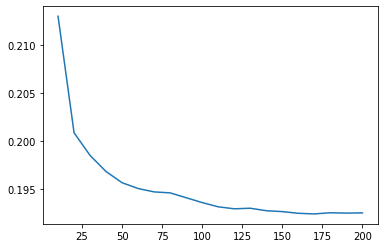

In [18]:
plt.plot(range(10,201,10), rmse_arr)
plt.show()

After which value of `n_estimators` does RMSE stop improving?

- 10
- 50
- 70
- <b>120<b>

<b> At 120 RMSE stopped improving <b>

## Question 4

Let's select the best `max_depth`:

* Try different values of `max_depth`: `[10, 15, 20, 25]`
* For each of these values, try different values of `n_estimators` from 10 till 200 (with step 10)
* Fix the random seed: `random_state=1`

In [19]:
all_rmse = {}
for max_depth in [10, 15, 20, 25]:
    rmse_arr = []
    for n in range(10,201, 10):
        forest_model = RandomForestRegressor(n_estimators=n, max_depth=max_depth, random_state=1,n_jobs=6)
        forest_model.fit(train_set, y_train)
        
        y_pred = forest_model.predict(validation_set)
        value = rmse(y_valid, y_pred)
        
        rmse_arr.append(value)
        
    all_rmse[max_depth] = rmse_arr
    


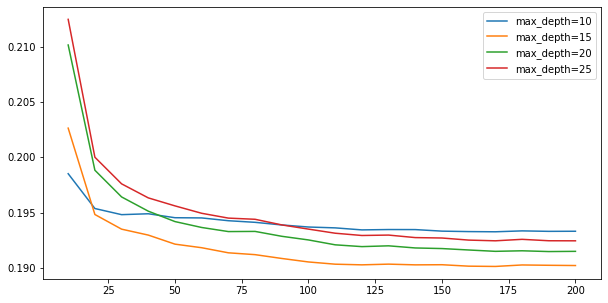

In [20]:
data_range = range(10,201, 10)

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(data_range, all_rmse[10],label='max_depth=10')
ax.plot(data_range, all_rmse[15],label='max_depth=15')
ax.plot(data_range, all_rmse[20],label='max_depth=20')
ax.plot(data_range, all_rmse[25],label='max_depth=25')
ax.legend()


plt.show()

What's the best `max_depth`:

* 10
* <b>15</b>
* 20
* 25

<b>Best max_depth is 15</b>

Bonus question (not graded):

Will the answer be different if we change the seed for the model?

<b>Let's see the answer with different seeds (and max_depth=15)</b> 

In [21]:
all_rmse = {}
for seed in [1, 5, 50, 100]:
    rmse_arr = []
    for n in range(10,201, 10):
        forest_model = RandomForestRegressor(n_estimators=n, max_depth=15, random_state=seed,n_jobs=6)
        forest_model.fit(train_set, y_train)
        
        y_pred = forest_model.predict(validation_set)
        value = rmse(y_valid, y_pred)
        
        rmse_arr.append(value)
        
    all_rmse[seed] = rmse_arr
    


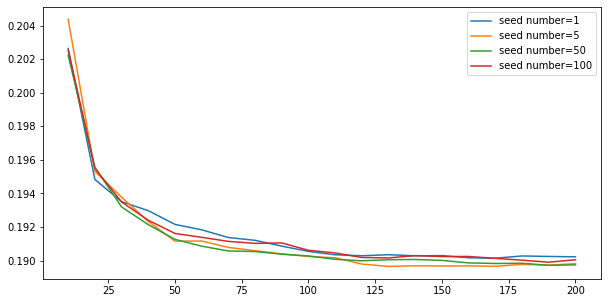

In [22]:
################ Plot the learning curve for different seed numbers ################
data_range = range(10,201, 10)

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(data_range, all_rmse[1],label='seed number=1')
ax.plot(data_range, all_rmse[5],label='seed number=5')
ax.plot(data_range, all_rmse[50],label='seed number=50')
ax.plot(data_range, all_rmse[100],label='seed number=100')
ax.legend()


plt.show()

<b>As We can see with different seed numbers the result is slightly different</b>

## Question 5

We can extract feature importance information from tree-based models. 

At each step of the decision tree learning algorith, it finds the best split. 
When doint it, we can calculate "gain" - the reduction in impurity before and after the split. 
This gain is quite useful in understanding what are the imporatant features 
for tree-based models.

In Scikit-Learn, tree-based models contain this information in the `feature_importances_` field. 

For this homework question, we'll find the most important feature:

* Train the model with these parametes:
    * `n_estimators=10`,
    * `max_depth=20`,
    * `random_state=1`,
    * `n_jobs=-1` (optional)
* Get the feature importance information from this model

In [23]:
forest_model = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=1, n_jobs=6)
forest_model.fit(train_set, y_train)

RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=6, random_state=1)

In [24]:
################ Create a Dataframe showing importance value of every columns ################
feature_importance_df = pd.DataFrame(forest_model.feature_importances_)
feature_importance_df.index = dv.feature_names_
feature_importance_df.columns = ['importance_value']
feature_importance_df.sort_values(ascending=False, by='importance_value')

,importance_value
room_type=Entire home/apt,0.391898
longitude,0.154101
latitude,0.152775
availability_365,0.076264
reviews_per_month,0.054430
minimum_nights,0.053252
number_of_reviews,0.041594
neighbourhood_group=Manhattan,0.034047
calculated_host_listings_count,0.030102
room_type=Shared room,0.005023


What's the most important feature? 

* `neighbourhood_group=Manhattan`
* `room_type=Entire home/apt`	
* `longitude`
* `latitude`

<b>As we saw, The Most important feature is _room_type=Entire home/apt_.</b>

## Question 6

Now let's train an XGBoost model! For this question, we'll tune the `eta` parameter

* Install XGBoost
* Create DMatrix for train and validation
* Create a watchlist
* Train a model with these parameters for 100 rounds:

```
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
```

In [25]:
dtrain = xgb.DMatrix(train_set, label=y_train, feature_names=dv.feature_names_)
dval = xgb.DMatrix(validation_set, label=y_valid, feature_names=dv.feature_names_)

In [26]:
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'nthread': 8,
    'eval_metric':'rmse',

    'seed': 1,
    'verbosity': 1,
}

watch_list = [(dtrain, 'train'),(dval, 'val')]

xgb_model = xgb.train(xgb_params ,dtrain, num_boost_round=100,
                      evals=watch_list, verbose_eval=10)

[0]	train-rmse:3.02752	val-rmse:3.02415
[10]	train-rmse:0.43912	val-rmse:0.44981
[20]	train-rmse:0.41716	val-rmse:0.43691
[30]	train-rmse:0.40712	val-rmse:0.43543
[40]	train-rmse:0.40103	val-rmse:0.43466
[50]	train-rmse:0.39446	val-rmse:0.43384
[60]	train-rmse:0.38743	val-rmse:0.43404
[70]	train-rmse:0.38117	val-rmse:0.43467
[80]	train-rmse:0.37668	val-rmse:0.43526
[90]	train-rmse:0.36998	val-rmse:0.43539
[99]	train-rmse:0.36478	val-rmse:0.43621


Now change `eta` first to `0.1` and then to `0.01`

In [27]:
xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'nthread': 8,
    'eval_metric':'rmse',

    'seed': 1,
    'verbosity': 1,
}

watch_list = [(dtrain, 'train'),(dval, 'val')]

xgb_model = xgb.train(xgb_params ,dtrain, num_boost_round=100,
                      evals=watch_list, verbose_eval=10)

[0]	train-rmse:3.87217	val-rmse:3.86889
[10]	train-rmse:1.41910	val-rmse:1.41786
[20]	train-rmse:0.64528	val-rmse:0.64883
[30]	train-rmse:0.46186	val-rmse:0.47101
[40]	train-rmse:0.42770	val-rmse:0.44150
[50]	train-rmse:0.41868	val-rmse:0.43589
[60]	train-rmse:0.41432	val-rmse:0.43460
[70]	train-rmse:0.41059	val-rmse:0.43361
[80]	train-rmse:0.40747	val-rmse:0.43306
[90]	train-rmse:0.40478	val-rmse:0.43280
[99]	train-rmse:0.40277	val-rmse:0.43250


In [28]:
xgb_params = {
    'eta': 0.01, 
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'nthread': 8,
    'eval_metric':'rmse',

    'seed': 1,
    'verbosity': 1,
}

watch_list = [(dtrain, 'train'),(dval, 'val')]

xgb_model = xgb.train(xgb_params ,dtrain, num_boost_round=100,
                      evals=watch_list, verbose_eval=10)

[0]	train-rmse:4.25336	val-rmse:4.25010
[10]	train-rmse:3.85242	val-rmse:3.84921
[20]	train-rmse:3.49030	val-rmse:3.48719
[30]	train-rmse:3.16332	val-rmse:3.16029
[40]	train-rmse:2.86817	val-rmse:2.86533
[50]	train-rmse:2.60185	val-rmse:2.59925
[60]	train-rmse:2.36167	val-rmse:2.35927
[70]	train-rmse:2.14519	val-rmse:2.14303
[80]	train-rmse:1.95022	val-rmse:1.94827
[90]	train-rmse:1.77472	val-rmse:1.77302
[99]	train-rmse:1.63198	val-rmse:1.63045


What's the best eta?

* 0.3
* <b>0.1</b>
* 0.01

<b>Best eta value is 0.1 as we saw in the results </b>

## Submit the results


Submit your results here: https://forms.gle/wQgFkYE6CtdDed4w8

It's possible that your answers won't match exactly. If it's the case, select the closest one.


## Deadline


The deadline for submitting is 20 October 2021, 17:00 CET (Wednesday). After that, the form will be closed.

